# Import Module

In [20]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
#from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [2]:
variables = ['tas']
variable = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ ($K$)'

### Paths

In [32]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [33]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [34]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

# Get data : obs, PPE, p1

In [35]:
path_observation = '/data/scratch/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'

In [36]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']
df_obs['ta'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'
df_obs

time  temperature       clim          ta
lat        lon                                                  
-88.927735 0.00000    1979.0     0.768801 -25.193111  248.725677
           1.40625    1979.0     0.769734 -25.215549  248.704178
           2.81250    1979.0     0.770550 -25.236740  248.683807
           4.21875    1979.0     0.771259 -25.256731  248.664520
           5.62500    1979.0     0.771860 -25.276089  248.645767
...                      ...          ...        ...         ...
 88.927735 352.96875  1981.0     0.004460 -30.711264  242.443192
           354.37500  1981.0    -0.004911 -30.734428  242.410660
           355.78125  1981.0    -0.016334 -30.728228  242.405426
           357.18750  1981.0    -0.024906 -30.703251  242.421844
           358.59375  1981.0    -0.041427 -30.653141  242.455429

[1179648 rows x 4 columns]

In [37]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    time         (lat, lon) float64 1.98e+03 1.98e+03 ... 1.98e+03 1.98e+03
    temperature  (lat, lon) float32 0.17527 0.17550375 ... -0.16200545
    clim         (lat, lon) float32 -46.88067 -46.921864 ... -19.784966
    ta           (lat, lon) float32 226.4446 226.40364 ... 253.20612 253.20302

In [38]:
# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, variables)

In [39]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    i=i+1

In [40]:
amip['p1'] = p1_amip

In [41]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [42]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [43]:
# Mean wheigted with cos(lat) : 
lats = matrix['lat'][:]
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat).drop(labels='height').values
W =wgts[np.newaxis,:,np.newaxis]
#W

In [44]:
list_tmp = W[0,:,0]
list_W = []
list_lat = []
list_lon = []
list_mb = []

for j in range(0,256,1) :
    for i in range(0,128,1) :
        list_W.append(list_tmp[i])
        list_lat.append(float(amip['p1']['lat'][i]))
        list_lon.append(float(amip['p1']['lon'][j]))
        #list_mb.append(k)

In [45]:
df = pd.DataFrame(list_W, columns=['W'])#.transpose()
df['lat'] = list_lat
df['lon'] = list_lon
#df['dummy'] = list_dummy
df_W = df.groupby(['lat','lon']).mean().to_xarray()
da_W = df_W.to_array(dim='time')
#df_W = df.drop(dims='variable')
df_W['W']

<xarray.DataArray 'W' (lat: 128, lon: 256)>
array([[0.13679714, 0.13679714, 0.13679714, ..., 0.13679714, 0.13679714,
        0.13679714],
       [0.20723052, 0.20723052, 0.20723052, ..., 0.20723052, 0.20723052,
        0.20723052],
       [0.25940918, 0.25940918, 0.25940918, ..., 0.25940918, 0.25940918,
        0.25940918],
       ...,
       [0.25940918, 0.25940918, 0.25940918, ..., 0.25940918, 0.25940918,
        0.25940918],
       [0.20723052, 0.20723052, 0.20723052, ..., 0.20723052, 0.20723052,
        0.20723052],
       [0.13679714, 0.13679714, 0.13679714, ..., 0.13679714, 0.13679714,
        0.13679714]])
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [46]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'tas' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

In [47]:
anom_w = (anom*df_W)#.to_array()
anom_w['W']

<xarray.DataArray 'W' (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    height   float64 2.0
Dimensions without coordinates: time

In [48]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w['W'], center=False, weights=None)

In [49]:
eof = solver.eofsAsCovariance(neofs=102, pcscaling=0)
pc = solver.pcs(npcs=102, pcscaling=0)
eigen = solver.eigenvalues()

In [50]:
varFrac = solver.varianceFraction(neigs=102)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 102)>
array([5.90293079e-01, 1.43160585e-01, 5.86399346e-02, 3.04170113e-02,
       2.78308094e-02, 2.00188325e-02, 1.52567109e-02, 9.89492518e-03,
       7.96787075e-03, 7.09969061e-03, 6.39898056e-03, 5.59995126e-03,
       4.53449764e-03, 4.23213902e-03, 4.00317494e-03, 3.81854741e-03,
       3.40578336e-03, 2.74169299e-03, 2.61901464e-03, 2.54709181e-03,
       2.36223070e-03, 2.24442197e-03, 2.15818221e-03, 1.97451168e-03,
       1.78778191e-03, 1.72751880e-03, 1.62211831e-03, 1.42821614e-03,
       1.38803766e-03, 1.33157709e-03, 1.24683997e-03, 1.20899284e-03,
       1.07112175e-03, 1.01154746e-03, 9.88032586e-04, 9.71362858e-04,
       9.56457618e-04, 8.63970763e-04, 8.38754875e-04, 8.07111489e-04,
       7.75419971e-04, 7.67657759e-04, 7.45388210e-04, 7.18737999e-04,
       7.10634986e-04, 6.37671984e-04, 6.31413911e-04, 5.93655355e-04,
       5.80577949e-04, 5.60450720e-04, 5.53151292e-04, 5.28599052e-04,
       5.11765090e-04, 4.84937203e-04, 4.78846152e-04, 4.66371663e-04,
       4.52311339e-04, 4.46727347e-04, 4.18031365e-04, 3.97372522e-04,
       3.95876924e-04, 3.84570687e-04, 3.75935678e-04, 3.53836064e-04,
       3.46113617e-04, 3.37205320e-04, 3.20545425e-04, 3.10284166e-04,
       3.05530398e-04, 3.02910912e-04, 2.91747677e-04, 2.88069704e-04,
       2.84380261e-04, 2.76528743e-04, 2.71663054e-04, 2.64566882e-04,
       2.61635202e-04, 2.58077125e-04, 2.46992629e-04, 2.43267875e-04,
       2.39466651e-04, 2.30114300e-04, 2.20565801e-04, 2.17847714e-04,
       2.13451740e-04, 2.04083724e-04, 2.02857891e-04, 1.89606441e-04,
       1.88097032e-04, 1.84579775e-04, 1.81998473e-04, 1.78135863e-04,
       1.71382037e-04, 1.67676267e-04, 1.57839612e-04, 1.55093235e-04,
       1.52560650e-04, 1.48698712e-04, 1.41541687e-04, 1.40478610e-04,
       1.38906046e-04, 1.26445393e-04])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100 101
Attributes:
    long_name:  variance_fractions

# Bootstrap

In [183]:
def MultiLinReg(X_train, pc_train, EOF_nb, x_pred, variable) :
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")    
    # Let's use the model equation : 
    y_train = pc_train[:,EOF_nb-1]
    print(y_train)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]
  
    tmp = Coeffs.values*x_pred
    y_pred = tmp.sum()+R
    
    return y_pred

In [57]:
from sklearn.model_selection import train_test_split
EOF_nb = 1
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = anom_w['W'][1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [58]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(y_train, center=False, weights=None)

In [193]:
eof = solver.eofsAsCovariance(neofs=102, pcscaling=0)
pc_train = solver.pcs(npcs=102, pcscaling=0)

In [194]:
y_train

<xarray.DataArray 'W' (time: 91, lat: 128, lon: 256)>
dask.array<getitem, shape=(91, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    height   float64 2.0
Dimensions without coordinates: time

In [184]:
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")  

x_pred = X_train
EOF_nc = 1
test = MultiLinReg(X_train, pc_train, EOF_nb, x_pred, variable)
test
#test = [y_pred_IS]*30
#df_test = pd.DataFrame(test)
#test = pd.DataFrame(test, columns=param_names)#.iloc[0]
#test

<xarray.DataArray 'pcs' (time: 91)>
array([ 1.35285247e+02, -1.05622560e+02, -1.32218160e+02,  4.07552429e+01,
       -6.47342672e+01,  4.57025658e+01, -1.59419954e+02, -6.06214212e+01,
       -2.12932538e+02, -1.60213035e+02,  1.21701697e+02, -9.66037526e+01,
       -2.95731611e+01,  7.08440987e+00,  8.30969426e+01,  5.14113646e+01,
       -8.47138987e+01,  8.08483222e+01,  7.99463190e+00,  2.58990720e+02,
        1.21057368e+02, -8.86658904e+01,  1.18723834e+02, -1.81450283e+01,
       -6.43048994e+01, -1.42369890e+02, -4.72081098e+01,  2.22751654e+02,
       -2.31719161e+01, -2.34798586e+02,  9.08745443e+00, -3.53478238e+01,
       -6.84272685e+01,  1.73667888e+02, -5.61953563e+01, -1.00013151e+02,
        1.35285461e+02,  9.54940032e+00, -1.01317391e+02,  1.21812290e+02,
        6.35084454e+01,  1.25765395e+02,  1.69833251e+01, -5.09958751e+01,
       -4.79043566e+01, -2.51515419e+01,  1.30656561e+02,  3.72501996e+01,
        7.88351246e+01,  8.43971885e+01,  5.31880710e+01,  8.802

-831.2923624265003

In [128]:
[test]

[array([[ 3.08411852e+01,  3.32247074e+01,  3.39012127e+01, ...,
         -9.14641199e+00, -5.22881754e-01,  7.47815027e+00],
        [ 2.66856376e+01,  1.55453092e+01,  2.03782388e+01, ...,
          1.38758803e+00,  1.13916657e+01,  6.00072041e+00],
        [ 6.74143211e+00,  4.52109805e-01, -1.99819817e+00, ...,
          2.73252606e-01,  6.88066138e+00,  4.11324146e+00],
        ...,
        [-9.91034197e-02,  1.07478103e-02,  2.25139271e-01, ...,
          2.80716638e-01, -1.63837841e-01,  1.20380797e-02],
        [-1.57328921e-01, -1.90235578e-01, -7.98821550e-02, ...,
          1.18526451e-01,  4.31462143e-02, -2.84550732e-01],
        [-1.65715625e-02, -5.68551413e-02, -6.30388412e-02, ...,
          1.75720139e-02, -4.71044966e-02, -1.99273455e-02]])]

In [130]:
df_test = pd.DataFrame(test, columns=param_names)
df_test

,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,RAUTEFS,...,VVN,VVX,ALFX,FNEBC,GCTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,REFLCAPE
0,30.841185,33.224707,33.901213,11.943475,2.065919,20.724818,5.345693,-10.498377,-8.367575,-31.027091,...,-1.051154,7.799481,-5.683662,-3.010733,4.358570,26.759711,3.301113,-9.146412,-0.522882,7.478150
1,26.685638,15.545309,20.378239,-0.569777,-1.395600,7.220581,-0.958501,-1.362947,10.237900,4.103010,...,0.313766,-5.863941,1.587609,8.884443,1.985296,-4.503182,-1.833528,1.387588,11.391666,6.000720
2,6.741432,0.452110,-1.998198,9.354725,0.280734,-13.077294,1.448138,3.771004,2.394752,1.388200,...,2.419032,1.608063,8.705549,1.819023,0.245430,7.752899,0.597047,0.273253,6.880661,4.113241
3,1.137252,2.610622,4.624378,-2.893667,-1.495539,4.889493,2.458873,0.166207,-3.431916,1.138447,...,1.425205,4.996988,-4.080212,-4.934225,-0.695586,-1.669307,0.008134,1.555958,-2.659003,-6.931877
4,-8.589201,3.904349,-1.039558,2.736849,-2.378840,10.229675,0.349269,-0.796140,3.806270,0.878972,...,-1.642903,-2.142026,7.308211,3.898507,-0.249969,-0.009816,1.726516,-0.888116,4.599899,1.148829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,-0.115190,-0.006076,0.100702,0.078114,-0.286641,-0.242760,0.094929,-0.177946,-0.354137,0.053541,...,-0.096885,-0.013882,0.040823,-0.016024,0.227326,-0.250768,-0.025158,-0.164379,-0.377044,0.127348
87,-0.047443,0.117790,-0.105880,0.195602,0.274042,-0.107856,0.012936,-0.149049,-0.077657,0.185873,...,-0.622001,0.141171,0.150030,-0.055419,0.135772,-0.020897,0.026265,-0.084940,0.002578,-0.044417
88,-0.099103,0.010748,0.225139,-0.315742,0.257084,-0.123691,-0.197855,-0.090614,0.013667,0.048610,...,0.596522,-0.127872,-0.240740,0.045008,-0.279788,0.134131,0.043764,0.280717,-0.163838,0.012038
89,-0.157329,-0.190236,-0.079882,-0.251832,-0.318652,0.125230,-0.088421,0.279226,0.267753,-0.405724,...,-0.165109,0.248220,-0.061805,-0.276245,-0.228359,0.151833,-0.086274,0.118526,0.043146,-0.284551


In [ ]:
pc_test = solver.projectField(y_test, neofs=, weighted=False, eofscaling=0)

In [9]:
df_corr = pd.DataFrame(pc_PPE['modes_1'][0:80], columns=['pc_PPE'])
df_corr_OS = pd.DataFrame(pc_PPE['modes_1'][80:], columns=['modes_1'])
r_corr = {}
r_corr_OS = {}

for i in range(1,101,1) :
    
    df_corr['pc_PPE'] = pc_PPE['modes_'+str(i)][0:80]
    df_corr['pc_pred'] = df_pc['modes_'+str(i)]
    r_corr_tmp = np.corrcoef(df_corr['pc_PPE'], df_corr['pc_pred'])
    r_corr['modes_'+str(i)]  = r_corr_tmp[1,0]
    
    df_corr_OS['pc_PPE'] = pc_PPE['modes_'+str(i)][80:]
    df_corr_OS['pc_pred'] = df_pc_OS['modes_'+str(i)].values
    r_corr_OS_tmp = np.corrcoef(df_corr_OS['pc_PPE'], df_corr_OS['pc_pred'])
    r_corr_OS['modes_'+str(i)]  = r_corr_OS_tmp[1,0]


In [10]:
r_corr_list=[]
r_corr_OS_list = []

for i in range(1,101,1) : 
    r_tmp = r_corr['modes_'+str(i)]
    r_corr_OS_tmp = r_corr_OS['modes_'+str(i)]

    r_corr_list.append(r_tmp)
    r_corr_OS_list.append(r_corr_OS_tmp)

df_fig = pd.DataFrame(r_corr_list, columns=['r_corr'])
df_fig['r_corr_OS'] = r_corr_OS_list
df_fig['mode'] = range(1,101,1)
df_fig

,r_corr,r_corr_OS,mode
0,0.956573,0.843558,1
1,0.956432,0.878588,2
2,0.919586,0.789460,3
3,0.863847,0.434511,4
4,0.874352,0.564713,5
...,...,...,...
95,0.534438,-0.342728,96
96,0.600229,0.154736,97
97,0.444346,-0.019575,98
98,0.507491,-0.316405,99


# Figure

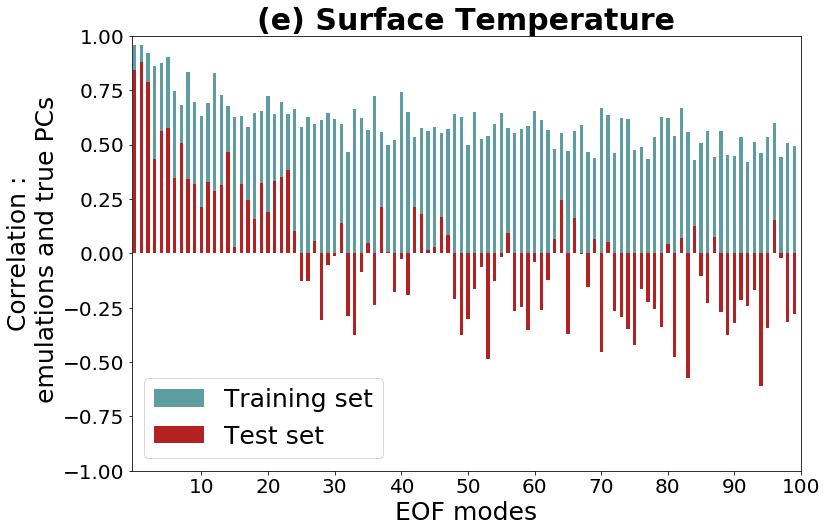

In [17]:
plt.figure(figsize=(12, 8))
    

ax = plt.gca()

df_fig.plot(kind='bar', x='mode', y='r_corr', color = 'cadetblue', alpha=1, linewidth=4, ax=ax)
df_fig.plot(kind='bar', x='mode', y='r_corr_OS', color='firebrick', linewidth=4, ax=ax)
#df_fig.plot(kind='line', x='mode', y='r_corr_pred', color='black', linestyle='dashed', linewidth=1.5, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
ax.set_ylim(-1, 1)
ax.set_xlabel('EOF modes', size = 25)
ax.set_ylabel('Correlation :\n emulations and true PCs', size = 25)
ax.set_title('(e) Surface Temperature', fontsize=30, 
             fontweight = 'bold')
#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xticks(range(10, 101, 10))
ax.set_xticklabels(range(10, 101, 10))

plt.xticks(rotation=0)

# Legend .................

legend = [ 'Training set', 'Test set']
#ax.get_legend().remove()
ax.legend(legend, fontsize=25) #bbox_to_anchor=(1.05, 1)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Fig2_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()